# ML Ptychography Demo
Train a small U-Net to predict (amplitude, phase) from diffraction patterns.

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from src.data_generation import generate_ml_pairs
from src.ml import PtychoNN, FCUNet, Trainer, TrainingConfig, create_datasets, count_parameters

diffraction: torch.Size([200, 64, 64]), amplitude: torch.Size([200, 64, 64]), phase: torch.Size([200, 64, 64])


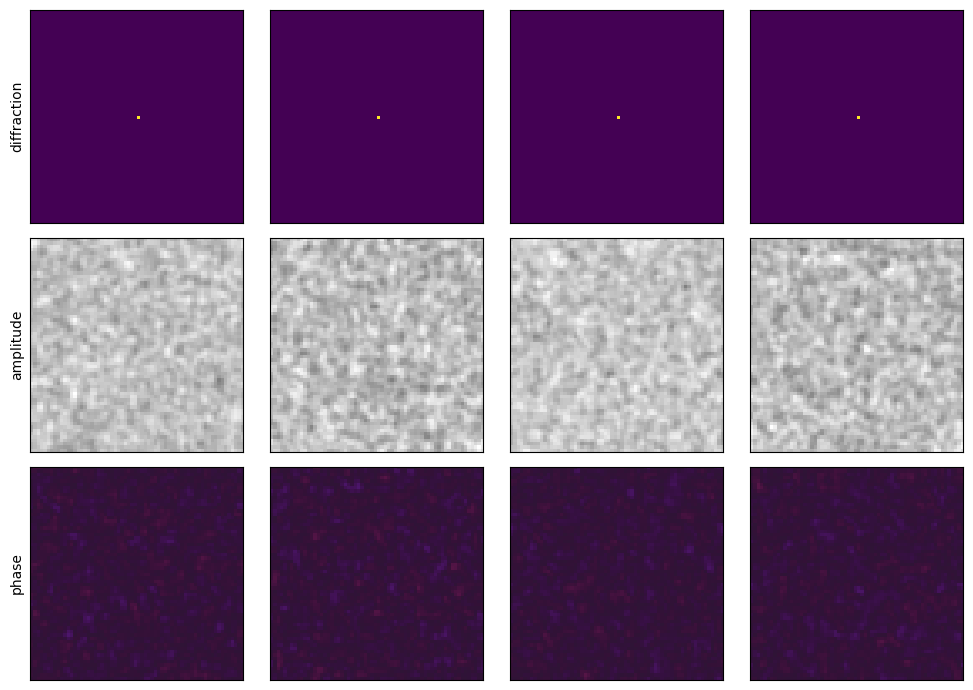

In [2]:
# generate synthetic training data
X, A, P = generate_ml_pairs(n_samples=200, size=64, seed=42)
print(f"diffraction: {X.shape}, amplitude: {A.shape}, phase: {P.shape}")

# quick look at a few samples
fig, axes = plt.subplots(3, 4, figsize=(10, 7))
for i in range(4):
    axes[0, i].imshow(np.log1p(X[i]), cmap='viridis')
    axes[1, i].imshow(A[i], cmap='gray', vmin=0, vmax=1)
    axes[2, i].imshow(P[i], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[0, 0].set_ylabel('diffraction')
axes[1, 0].set_ylabel('amplitude')
axes[2, 0].set_ylabel('phase')
for ax in axes.flat:
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()

In [3]:
# train/val split
train_ds, val_ds = create_datasets(X, A, P, train_ratio=0.8)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

In [4]:
# train PtychoNN
model = PtychoNN(in_channels=1, base_channels=16, depth=3)
print(f"parameters: {count_parameters(model):,}")

config = TrainingConfig(num_epochs=15, learning_rate=1e-3, device='cpu')
trainer = Trainer(model, config)
result = trainer.train(train_loader, val_loader)
print(f"best val loss: {result.best_val_loss:.4f}")

parameters: 461,074
best val loss: 0.2008


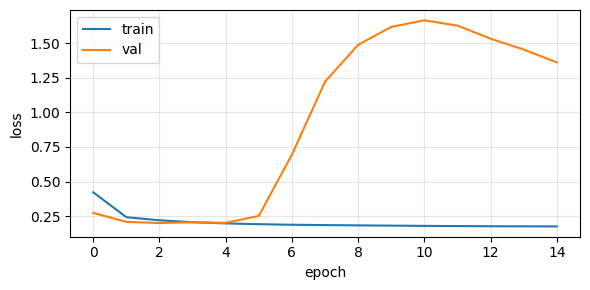

In [5]:
# training curves
plt.figure(figsize=(6, 3))
plt.plot(result.train_losses, label='train')
plt.plot(result.val_losses, label='val')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()

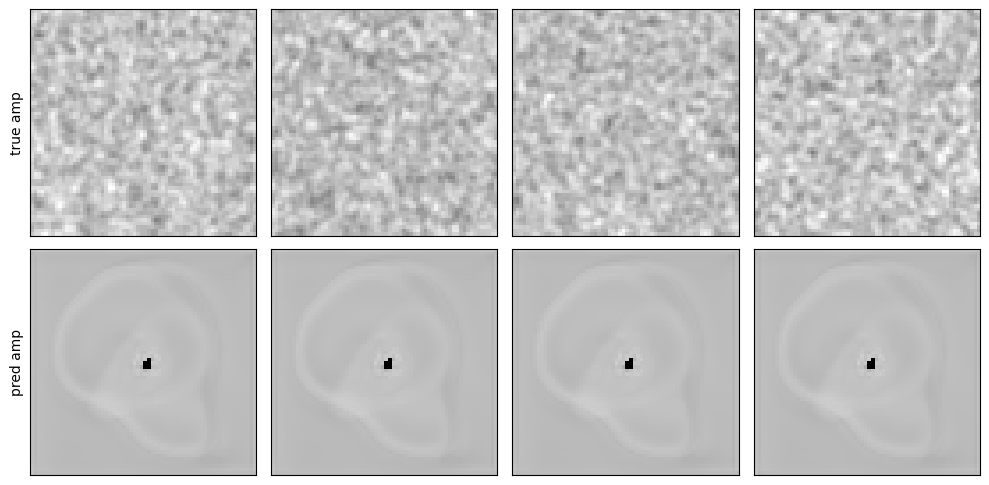

In [6]:
# check predictions on validation set
model.eval()
diff, amp_true, phase_true = next(iter(val_loader))

with torch.no_grad():
    amp_pred, phase_pred = model(diff)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    axes[0, i].imshow(amp_true[i, 0], cmap='gray', vmin=0, vmax=1)
    axes[1, i].imshow(amp_pred[i, 0].detach(), cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_ylabel('true amp')
axes[1, 0].set_ylabel('pred amp')
for ax in axes.flat:
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()

## Multi-slice for thick samples

For thick samples, we predict multiple slices at different depths through the sample.

In [7]:
# FCU-Net can output multiple slices
model_ms = FCUNet(in_channels=1, base_channels=16, depth=3, num_slices=4)
print(f"parameters: {count_parameters(model_ms):,}")

# test forward pass
test_in = torch.randn(1, 1, 64, 64)
amp_out, phase_out = model_ms(test_in)
print(f"output shape: {amp_out.shape}  # (batch, slices, H, W)")

parameters: 303,832
output shape: torch.Size([1, 4, 64, 64])  # (batch, slices, H, W)


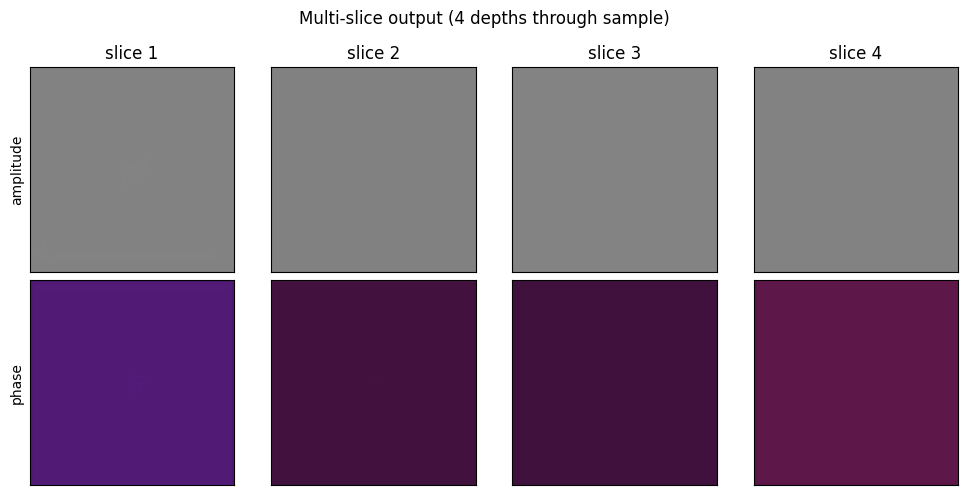

In [8]:
# visualize the 4 slice outputs (untrained, just showing structure)
model_ms.eval()
with torch.no_grad():
    amp_slices, phase_slices = model_ms(diff[:1])

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    axes[0, i].imshow(amp_slices[0, i], cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'slice {i+1}')
    axes[1, i].imshow(phase_slices[0, i], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[0, 0].set_ylabel('amplitude')
axes[1, 0].set_ylabel('phase')
for ax in axes.flat:
    ax.set_xticks([]); ax.set_yticks([])
plt.suptitle('Multi-slice output (4 depths through sample)')
plt.tight_layout()